# Entrenamiento en X  Y Z


In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

import sys
sys.path.append('../')
from Utils import plotter as plots

In [6]:
# Obtención, drop y normalización de los datos.
x_test		= pd.read_excel("../Train_Test/Dataset_Separado/x_test_new.xlsx")
x_train		= pd.read_excel("../Train_Test/Dataset_Separado/x_train_new.xlsx")
y_test		= pd.read_excel("../Train_Test/Dataset_Separado/y_test_new.xlsx")
y_train		= pd.read_excel("../Train_Test/Dataset_Separado/y_train_new.xlsx")

x_train 	= x_train.drop(columns = ['latitude_pos_tx', 'longitude_pos_tx', 'elevation_pos_tx', 'year'])
x_test		= x_test.drop(columns =['latitude_pos_tx', 'longitude_pos_tx', 'elevation_pos_tx', 'year'])

R0 = 6.371E6 #[m]
y_train_xyz = y_train/R0
y_test_xyz	= y_test/R0

In [7]:
# Escalado.
scaler_x	= MinMaxScaler()
scaler_y	= MinMaxScaler()
scaler_z	= MinMaxScaler()

y_train_x_scaled	= scaler_x.fit_transform(y_train_xyz.iloc[:,:100])
y_train_y_scaled	= scaler_y.fit_transform(y_train_xyz.iloc[:,100:200])
y_train_z_scaled	= scaler_z.fit_transform(y_train_xyz.iloc[:,200:300])

y_test_x_scaled	= scaler_x.transform(y_test_xyz.iloc[:,:100])
y_test_y_scaled	= scaler_y.transform(y_test_xyz.iloc[:,100:200])
y_test_z_scaled	= scaler_z.transform(y_test_xyz.iloc[:,200:300])



In [8]:
# Callbacks.
reduce_lr		= ReduceLROnPlateau(
	monitor		= 'val_loss',
  patience	= 20,
  factor		= 0.5
)

In [9]:
# definiciones Previas.
act_name	= 'relu'
l2_reg		= 0.0007
epochs		= 700
b_s				= 64
optimizer = Adam(learning_rate=0.001)

# Arquitectura.
inputs	= Input(shape=(5,))
encoded	= Dense(32,	 activation	= act_name, kernel_regularizer = l2(l2_reg))(inputs)
encoded = Dense(128, activation = act_name, kernel_regularizer = l2(l2_reg))(encoded)
encoded = Dense(256, activation = act_name, kernel_regularizer = l2(l2_reg))(encoded)
encoded = Dense(512, activation = act_name, kernel_regularizer = l2(l2_reg))(encoded)
encoded = Dense(512, activation = act_name, kernel_regularizer = l2(l2_reg))(encoded)

decoded_x = Dense(100, activation = 'linear', name = 'x')(encoded)
decoded_y = Dense(100, activation = 'linear', name = 'y')(encoded)
decoded_z = Dense(100, activation = 'linear', name = 'z')(encoded)

# Definición modelo con multiples salidas.
model_xyz = Model(inputs	= inputs, outputs=[decoded_x, decoded_y, decoded_z])
model_xyz.compile(optimizer = optimizer, loss = 'mae')
model_xyz.summary()

# Entrenamiento.
history_xyz = model_xyz.fit(x_train,
                            [y_train_x_scaled,
                            y_train_y_scaled,
                            y_train_z_scaled],
                            epochs						= epochs,
														batch_size				= b_s,
                            validation_split	= 0.1,
                            callbacks					= [reduce_lr],
                          	)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        192 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      4,224 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     33,024 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    131,584 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │    262,656 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x (Dense)           │ (None, 100)       │     51,300 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y (Dense)           │ (None, 100)       │     51,300 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Dense)           │ (None, 100)       │     51,300 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 585,580 (2.23 MB)

 Trainable params: 585,580 (2.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 11.0245 - x_loss: 3.4946 - y_loss: 3.7933 - z_loss: 3.1507 - val_loss: 0.7364 - val_x_loss: 0.1299 - val_y_loss: 0.1347 - val_z_loss: 0.1550 - learning_rate: 0.0010
Epoch 2/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7028 - x_loss: 0.1238 - y_loss: 0.1361 - z_loss: 0.1496 - val_loss: 0.6046 - val_x_loss: 0.1070 - val_y_loss: 0.1069 - val_z_loss: 0.1300 - learning_rate: 0.0010
Epoch 3/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6089 - x_loss: 0.1088 - y_loss: 0.1148 - z_loss: 0.1305 - val_loss: 0.5279 - val_x_loss: 0.0857 - val_y_loss: 0.0869 - val_z_loss: 0.1055 - learning_rate: 0.0010
Epoch 4/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5521 - x_loss: 0.0943 - y_loss: 0.0998 - z_loss: 0.1140 - val_loss: 0.5334 - val_x_loss: 0.0894 - val_y_loss: 0.0937 - val_z_loss: 0.1087 - learning_rate: 0.0010
Epoch 5/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5255 - x_loss: 0.0879 - y_loss: 0.0904 - 

In [10]:
loss = model_xyz.evaluate(x_test,[y_test_x_scaled,
																	y_test_y_scaled,
																	y_test_z_scaled],
													)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0597 - x_loss: 0.0105 - y_loss: 0.0112 - z_loss: 0.0128


In [20]:
idx = 50
pred_x_scaled, pred_y_scaled, pred_z_scaled = model_xyz.predict(np.expand_dims(x_test.iloc[idx], axis = 0))
pred_x = scaler_x.inverse_transform(pred_x_scaled).flatten()
pred_y = scaler_y.inverse_transform(pred_y_scaled).flatten()
pred_z = scaler_z.inverse_transform(pred_z_scaled).flatten()
true_x = y_test_xyz.iloc[idx,	 	 :100].to_numpy()
true_y = y_test_xyz.iloc[idx,	100:200].to_numpy()
true_z = y_test_xyz.iloc[idx, 200:300].to_numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


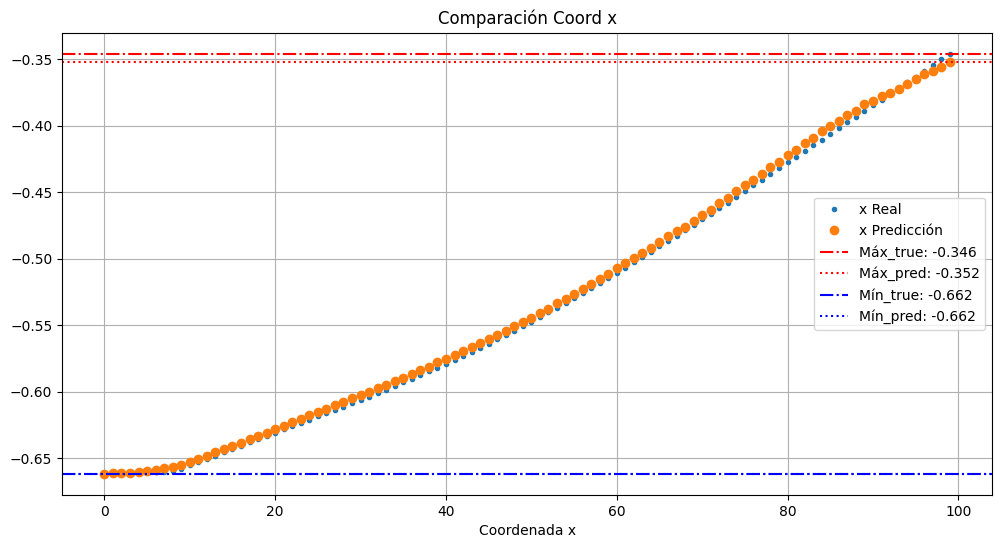

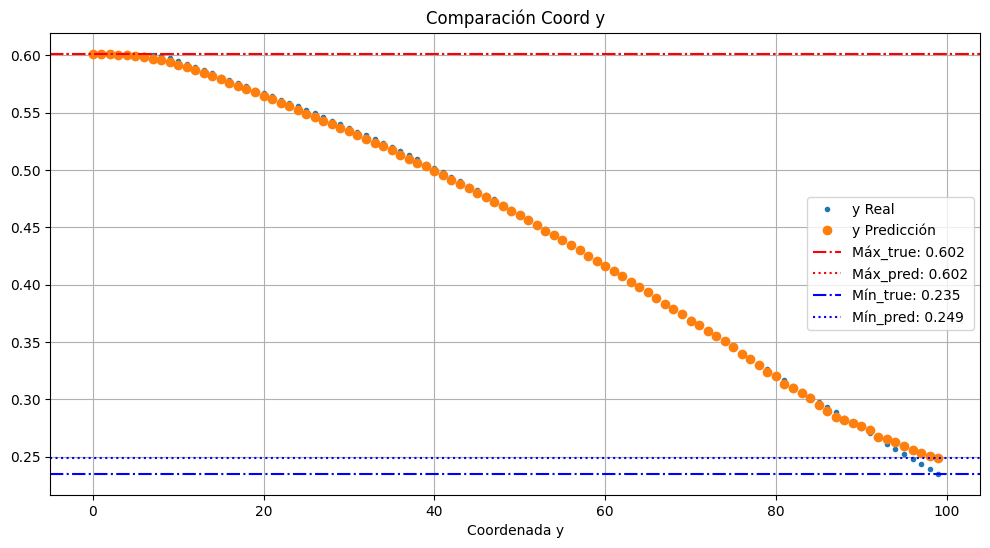

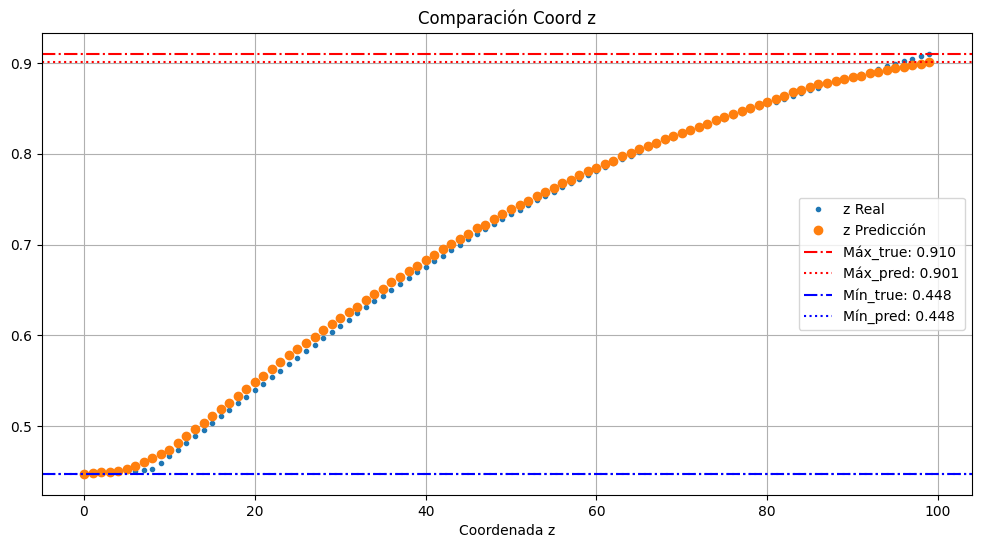

In [21]:
plots.plot_1D(true_x, pred_x,'x')
plots.plot_1D(true_y, pred_y,'y')
plots.plot_1D(true_z, pred_z,'z')



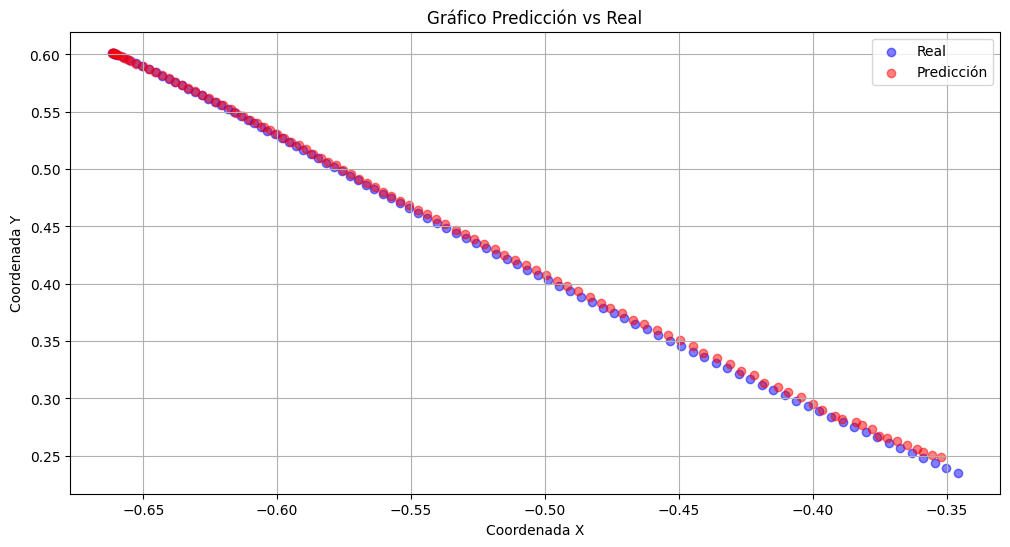

In [22]:
plots.plot_2D(true_x, true_y, pred_x, pred_y)

In [23]:
import pickle

save_model = True

if save_model:
    model_xyz.save('../modelos_entrenamiento/mod_x_y_z_R0/modelo1/modelo1_xyz.keras')

    with open('../modelos_entrenamiento/mod_x_y_z_R0/modelo1/scaler_x.pkl', 'wb') as file:
        pickle.dump(scaler_x, file)

    with open('../modelos_entrenamiento/mod_x_y_z_R0/modelo1/scaler_y.pkl', 'wb') as file:
        pickle.dump(scaler_y, file)

    with open('../modelos_entrenamiento/mod_x_y_z_R0/modelo1/scaler_z.pkl', 'wb') as file:
        pickle.dump(scaler_z, file)
